# Validation for quantile delta change 

In [1]:
import calendar
import sys
import gc

import xarray as xr
from xclim import sdba
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import xesmf as xe
import dask.diagnostics
import cmdline_provenance as cmdprov
import dask
import cmocean
import seaborn as sns
import pandas as pd

sys.path.append('/g/data/wp00/shared_code/qqscale')
import utils

ERROR 1: PROJ: proj_create_from_database: Open of /g/data/xv83/dbi599/miniconda3/envs/qqscale/share/proj failed


In [2]:
dask.diagnostics.ProgressBar().register()

In [4]:
# Parameters
adjustment_file = "/g/data/wp00/data/QQ-CMIP6/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/pr/v20191115/pr-ssr-qdm-multiplicative-monthly-q100-adjustment-factors_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20560101-20851231_wrt_19950101-20141231.nc"
qq_file = "/g/data/wp00/data/QQ-CMIP6/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/pr/v20191115/pr-ssr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_AUS-r005_20560101-20851231_qdm-multiplicative-monthly-q100-linear_AGCD-19900101-20191231_historical-19950101-20141231.nc"
hist_units = "mm day-1"
ref_units = "mm day-1"
target_units = "mm day-1"
output_units = "mm day-1"
hist_var = "pr"
ref_var = "pr"
target_var = "precip"
scaling = "multiplicative"
hist_files = "/g/data/wp00/data/QQ-CMIP6/ACCESS-ESM1-5/historical/r1i1p1f1/day/pr/v20191115/pr-ssr_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_19950101-20141231.nc"
ref_files = "/g/data/wp00/data/QQ-CMIP6/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/pr/v20191115/pr-ssr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20560101-20851231.nc"
target_files = "/g/data/wp00/data/AGCD/precip-ssr_AGCD_r005_19900101-20191231_daily.nc"
hist_time_bounds = "1995-01-01 2014-12-31"
ref_time_bounds = "2056-01-01 2085-12-31"
target_time_bounds = "1990-01-01 2019-12-31"

In [5]:
# Required parameters
assert 'scaling' in locals(), "Must provide the scaling method (option -p scaling {name})"
assert 'hist_var' in locals(), "Must provide an historical variable name (option -p hist_var {name})"
assert 'ref_var' in locals(), "Must provide a reference variable name (option -p ref_var {name})"
assert 'target_var' in locals(), "Must provide a target variable name (option -p target_var {name})"
assert 'hist_units' in locals(), "Must provide historical units (option -p hist_units {units})"
assert 'ref_units' in locals(), "Must provide reference units (option -p ref_units {units})"
assert 'target_units' in locals(), "Must provide target units (option -p target_units {units})"
assert 'output_units' in locals(), "Must provide output units (option -p output_units {units})"
assert 'adjustment_file' in locals(), "Must provide an adjustment factors file (option -p adjustment_file {file path})"
assert 'hist_files' in locals(), """Must provide historical data files (option -p hist_files {"file paths"})"""
assert 'ref_files' in locals(), """Must provide reference data files (option -p ref_files {"file paths"})"""
assert 'target_files' in locals(), """Must provide target data files (option -p target_files {"file paths"})"""
assert 'qq_file' in locals(), "Must provide an qq-scaled data file (option -p qq_file {file path})"
assert 'hist_time_bounds' in locals(), """Must provide time bounds for historical data (option -p hist_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""
assert 'ref_time_bounds' in locals(), """Must provide time bounds for reference data (option -p ref_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""
assert 'target_time_bounds' in locals(), """Must provide time bounds for target data (option -p target_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""

In [6]:
hist_files = hist_files.split()
ref_files = ref_files.split()
target_files = target_files.split()

hist_time_bounds = hist_time_bounds.split()
ref_time_bounds = ref_time_bounds.split()
target_time_bounds = target_time_bounds.split()

## Read data

In [9]:
ds_adjust = xr.open_dataset(adjustment_file)

In [10]:
ds_hist = utils.read_data(
    hist_files,
    hist_var,
    time_bounds=hist_time_bounds,
    input_units=hist_units,
    output_units=output_units,
)

<xarray.DataArray 'pr' (time: 7305, lat: 145, lon: 192)>
dask.array<xarray-pr, shape=(7305, 145, 192), dtype=float64, chunksize=(7305, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1995-01-01T12:00:00 ... 2014-12-31T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    comment:        includes both liquid and solid phases
    units:          mm day-1
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-11-15T17:33:19Z altered by CMOR: replaced missing va...

In [12]:
ds_ref = utils.read_data(
    ref_files,
    ref_var,
    time_bounds=ref_time_bounds,
    input_units=ref_units,
    output_units=output_units,
)

<xarray.DataArray 'pr' (time: 10958, lat: 145, lon: 192)>
dask.array<xarray-pr, shape=(10958, 145, 192), dtype=float64, chunksize=(10958, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2056-01-01T12:00:00 ... 2085-12-31T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    comment:        includes both liquid and solid phases
    units:          mm day-1
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-11-15T10:39:53Z altered by CMOR: replaced missing va...

In [14]:
ds_target = utils.read_data(
    target_files,
    target_var,
    time_bounds=target_time_bounds,
    input_units=target_units,
    output_units=output_units
)

<xarray.DataArray 'precip' (time: 10957, lat: 691, lon: 886)>
dask.array<xarray-precip, shape=(10957, 691, 886), dtype=float64, chunksize=(10957, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * time     (time) datetime64[ns] 1990-01-01T09:00:00 ... 2019-12-31T09:00:00
Attributes:
    analysis_time:                 2010-10-23 14:49:46 UTC
    analysis_version_number:       3.01
    cell_methods:                  time: sum
    frequency:                     daily
    length_scale_for_analysis:     80.0
    long_name:                     Daily precipitation
    number_of_stations_reporting:  2757
    source:                        Interpolated surface observations
    standard_name:                 lwe_thickness_of_precipitation_amount
    units:                         mm day-1

In [16]:
ds_qq = xr.open_dataset(qq_file)

In [18]:
lat_min_qq = ds_qq['lat'].values.min()
lat_max_qq = ds_qq['lat'].values.max()
lon_min_qq = ds_qq['lon'].values.min()
lon_max_qq = ds_qq['lon'].values.max()

## Australia-wide

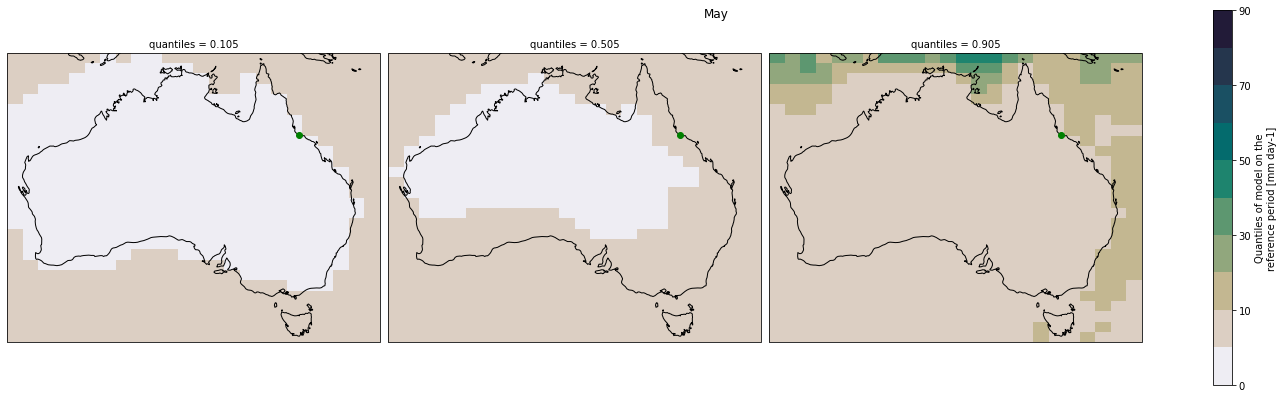

In [22]:
quantile_spatial_plot(
    ds_adjust['hist_q'],
    example_month,
    'regular',
    levels=plot_config['general_levels'],
    lat_bounds=[lat_min_qq, lat_max_qq],
    lon_bounds=[lon_min_qq, lon_max_qq],
)

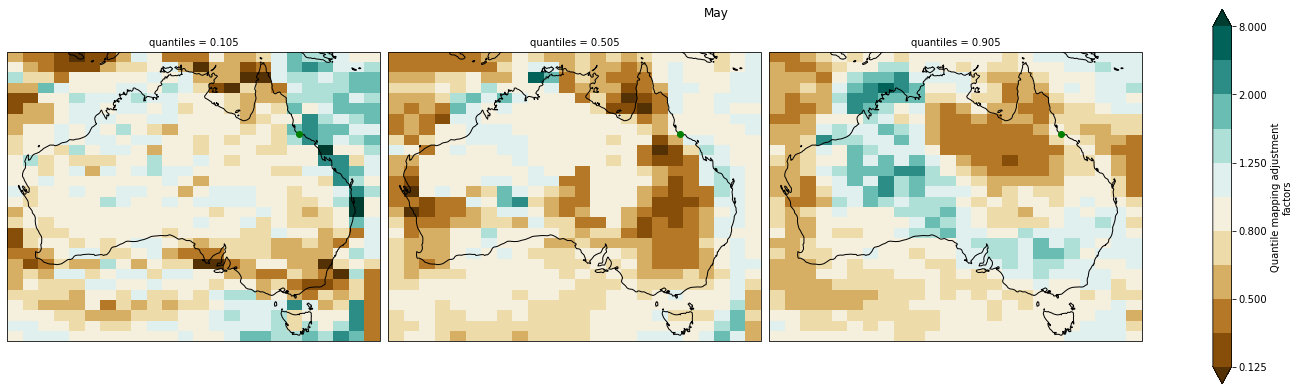

In [25]:
quantile_spatial_plot(
    ds_adjust['af'],
    example_month,
    'diverging',
    levels=plot_config['af_levels'],
    lat_bounds=[lat_min_qq, lat_max_qq],
    lon_bounds=[lon_min_qq, lon_max_qq],
)

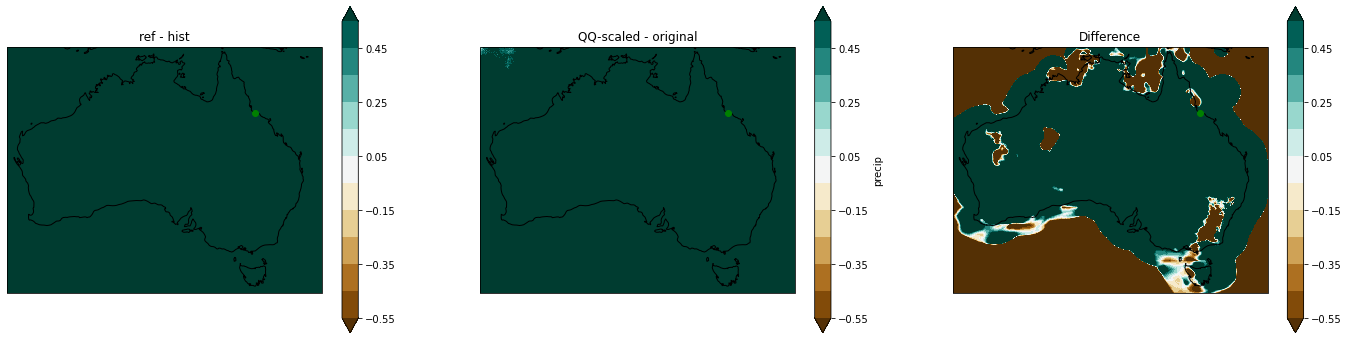

In [33]:
projection_spatial_plot(

)

## Points of interest

In [11]:
single_point_analysis(
    ds_hist[hist_var],
    ds_ref[ref_var],
    ds_target[target_var],
    ds_qq[target_var],
    ds_adjust,
    point_selection,
    months=[]
)

[########################################] | 100% Completed | 14.6s
